In [10]:
%%capture
# install and import libraries
%pip install ir_datasets
%pip install demoji

import re
import numpy as np
import pandas as pd
import ir_datasets
import demoji

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from tqdm.notebook import tqdm

from collections import Counter

from utils import *

pd.set_option('max_colwidth', 800)

In [347]:
# load dataset
dataset = ir_datasets.load("cord19/trec-covid")
print(
    f"queries: {dataset.queries_count()}, docs: {dataset.docs_count()}, qrels: {dataset.qrels_count()}"
)


queries: 50, docs: 192509, qrels: 69318


# Part 1: Analysis of Queries and Documents

In [451]:
%%capture
# convert the collection in a dataframe
queries = pd.DataFrame(dataset.queries_iter())
docs = pd.DataFrame(dataset.docs_iter())
qrels = pd.DataFrame(dataset.qrels_iter())

docs['date'] = pd.to_datetime(docs['date'])

In [ ]:
display(queries.sample(5))
display(docs.sample(5))
display(qrels.sample(5))

## Analysis of Documents

### Filter Covid documents

Visualize years distribution

In [ ]:
years = docs["date"].dt.year
years.dropna(inplace=True)
years = years.astype(int)

u_years, u_counts = np.unique(years, return_counts=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

sns.barplot(x=u_years, y=u_counts, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

sns.boxplot(x=years, ax=ax2, orient="h")
ax2.margins(0)

fig.tight_layout()

In [452]:
keywords = [
    "covid 19",
    "covid-19",
    "covid19",
    "sars-cov-2",
    "sarscov2",
    "sars cov 2",
    "2019-nCoV",
    "Wuhan virus",
    "Chinese flu",
    "COronaVIrusDisease",
]

keep = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
    text = " ".join([row["title"], row["abstract"]])
    if any(re.findall(r"|".join(keywords), text, re.IGNORECASE)):
        keep.add(index)

    # the few documents without date contain at least one keyword
    if row["date"] and row["date"] is not pd.NaT:
        if row["date"].year >= 2019:
            if any(
                re.findall(
                    r"coronavirus",
                    " ".join([row["title"], row["abstract"]]),
                    re.IGNORECASE,
                )
            ):
                keep.add(index)

print(f"{len(keep)}, {round(len(keep) / len(docs) * 100)}%")

docs = docs.iloc[list(keep)]

  0%|          | 0/192509 [00:00<?, ?it/s]

84048, 44%


### Duplicates

In [453]:
duplicated = sum(docs.duplicated())
duplicated_perc = duplicated / len(docs) * 100
print(f"duplicated rows: {duplicated}, {duplicated_perc:.2f}%")

duplicated rows: 179, 0.21%


In [458]:
def print_duplicates(docs, columns=None):
  if columns is None:
    columns = docs.columns

  for col in columns:
    d = sum(docs[col].duplicated())
    p = d / len(docs) * 100
    print(f"{col:10} {d:5} ({p:.2f}%)")

In [454]:
print("Duplicates for each column:")
print_duplicates(docs)

Duplicates for each column:
doc_id      1214 (1.44%)
title      23270 (27.69%)
doi        42094 (50.08%)
date       83589 (99.45%)
abstract   44984 (53.52%)


In [455]:
docs[docs["doc_id"] == "uym826bh"]

,doc_id,title,doi,date,abstract
29885,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,
34884,uym826bh,First Case of Covid-19 in the United States. Reply.,10.1056/nejmc2004794,2020-04-22,
39326,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,
48825,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,
50121,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,
58677,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,


In [456]:
docs.drop_duplicates(inplace=True)
docs[docs["doc_id"] == "uym826bh"]

,doc_id,title,doi,date,abstract
29885,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,
34884,uym826bh,First Case of Covid-19 in the United States. Reply.,10.1056/nejmc2004794,2020-04-22,


In [460]:
print_duplicates(docs, columns=["doc_id", "title", "doi", "abstract"])

doc_id      1035 (1.23%)
title      23091 (27.53%)
doi        41915 (49.98%)
abstract   44805 (53.42%)


In [473]:
duplicated = sum(docs.duplicated(["title", "abstract"]))
print(f"Duplicates (title, abstract): {duplicated} ({duplicated / len(docs) * 100:.2f}%)")

duplicated = sum(docs.duplicated(["doc_id", "title", "abstract"]))
print(f"Duplicates (doc_id, title, abstract): {duplicated} ({duplicated / len(docs) * 100:.2f}%)")

Duplicates (title, abstract): 17973 (21.43%)
Duplicates (doc_id, title, abstract): 198 (0.24%)


### Find Emojis

In [481]:
emojis = []
for index, row in tqdm(docs.iterrows(), total=len(docs)):
    e1 = demoji.findall(row["title"])
    if e1:
      emojis.extend(list(e1.keys()))

    e2 = demoji.findall(row["abstract"])
    if e2:
      emojis.extend(list(e2.keys()))

Counter(emojis)

  0%|          | 0/83869 [00:00<?, ?it/s]

Counter({'®': 287, '™': 73, '♦': 3, '©': 86, '⬇': 1, '▪': 7})

## Preprocessing

Apply the preprocess on the documents and the queries

In [ ]:
# global lists of tokens for wordclouds
titles = []
abstracts = []

docs_preprocessed = docs.copy()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
    title_tokens = preprocess(row["title"])
    abstract_tokens = preprocess(row["abstract"])

    docs_preprocessed.loc[index, "title"] = " ".join(title_tokens)
    docs_preprocessed.loc[index, "abstract"] = " ".join(abstract_tokens)

    titles.extend(title_tokens)
    abstracts.extend(abstract_tokens)

docs_preprocessed.to_pickle("data/docs_processed.pkl")


In [ ]:
queries_preprocessed = queries.copy()
for index, row in tqdm(queries.iterrows(), total=len(queries)):
    queries_preprocessed.loc[index, "title"] = " ".join(preprocess(row["title"]))
    queries_preprocessed.loc[index, "description"] = " ".join(
        preprocess(row["description"])
    )
    queries_preprocessed.loc[index, "narrative"] = " ".join(
        preprocess(row["narrative"])
    )

queries_preprocessed.to_pickle("data/queries_processed.pkl")


## Word Cloud

In [ ]:
counter_title = Counter(titles)
counter_abstract = Counter(abstracts)

wc1 = WordCloud(collocations=False, background_color="white", width=600, height=400)
wc2 = WordCloud(collocations=False, background_color="white", width=600, height=400)

wc_titles = wc1.fit_words(counter_title)
wc_abstracts = wc2.fit_words(counter_abstract)

wc_titles.to_file("out/wc_titles.png")
wc_abstracts.to_file("out/wc_abstracts.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(wc_titles)
ax1.set_title("Titles", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_abstracts)
ax2.set_title("Abstracts", fontsize=20)
ax2.axis("off")

fig.tight_layout()


## Token Statistics

In [ ]:
print("\n[Number of Tokens]")
print("Titles:", len(counter_title.keys()))
print("Abstracts:", len(counter_abstract.keys()))

k = 10
top_k_titles = [word for word, _ in counter_title.most_common(k)]
top_k_abstracts = [word for word, _ in counter_abstract.most_common(k)]

print(f"\n[Top {k} Most Common Tokens]")
print(f"Titles: {', '.join(top_k_titles)}")
print(f"Abstracts: {', '.join(top_k_abstracts)}")


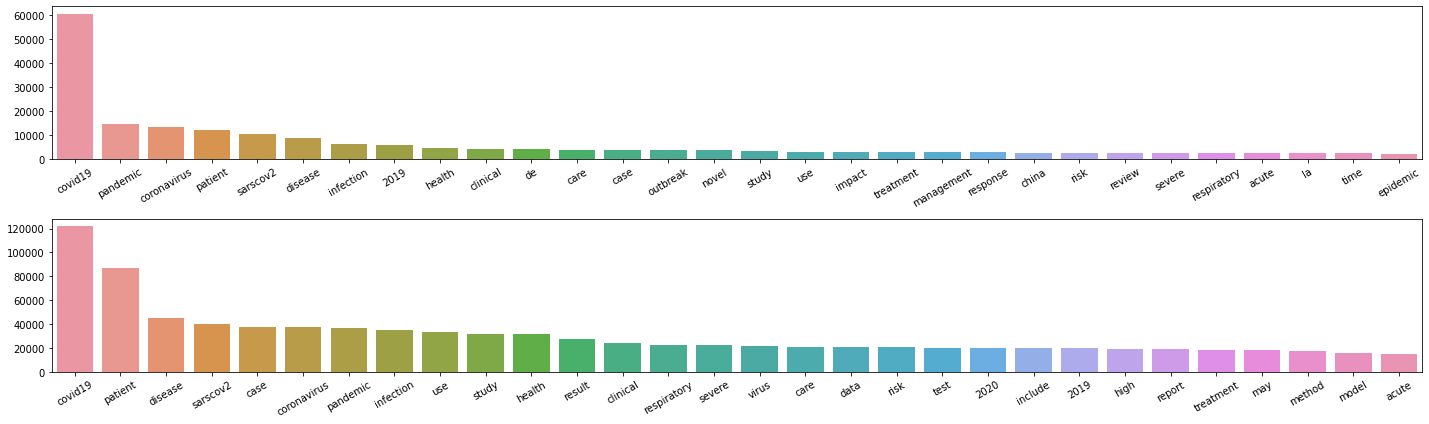

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 30

common_titles = dict(counter_title.most_common(k))
x_title = list(common_titles.keys())
y_title = list(common_titles.values())

common_abstracts = dict(counter_abstract.most_common(k))
x_abstract = list(common_abstracts.keys())
y_abstract = list(common_abstracts.values())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.barplot(x=x_title, y=y_title, ax=ax1)
sns.barplot(x=x_abstract, y=y_abstract, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
fig.tight_layout()


# Part 2: Basic Search

## Preprocessing of the query
Eliminate stopwords, remove punctuation. 
You can also perform any other pre-processing step.


* Lowcase
* Remove punctuation
* Remove extra whitespaces
* Normalize covid words
* Stop words
* Lemmatization
* Remove HTML tags
* Remove URLs
* Remove emojis



In [482]:
test_query_old = [
    "CoVid",
    "covid    19",
    "covid-19  influenza",
    "covid, influenza",
    "a covid flue is going on",
    "-term1 +term2",
    "{term1 term2}",
    "term1^2.3",
    "title:term1",
    "+title:term1",
    "title:(term1 term2)^2.3",
    "term1 -title:term2",
    '"term1 term2"',
    '+"term1 term2"',
    '"term1 term2"~n',
]

check_query_old = [
    "covid19",
    "covid19",
    "covid19 influenza",
    "covid19 influenza",
    "covid19 flue go",
    "-term1 +term2",
    "{ term1 term2 }",
    "term1^2.3",
    "title : term1",
    "+title : term1",
    "title : ( term1 term2 ) ^2.3",
    "term1 -title : term2",
    '" term1 term2 "',
    '+ " term1 term2 "',
    '" term1 term2 " ~n',
]


In [483]:
test_query = [
    "CoVid",
    "covid    19",
    "covid-19  influenza",
    "covid, influenza",
    "a covid flue is going on",
    "-term1 +term2",
    "{term1 term2}",
    "term1^2.3",
    "title:term1",
    "+title:term1",
    "title:(term1 term2)^2.3",
    "term1 -title:term2",
    '"term1 term2"',
    '+"term1 term2"',
    '"term1 term2"~n',
]

check_query = [
    "covid",
    "covid 19",
    "covid-19 influenza",
    "covid influenza",
    "covid flue go",
    "-term1 +term2",
    "{ term1 term2 }",
    "term1^2.3",
    "title : term1",
    "+title : term1",
    "title : ( term1 term2 ) ^2.3",
    "term1 -title : term2",
    '" term1 term2 "',
    '+ " term1 term2 "',
    '" term1 term2 " ~n',
]


In [484]:
preprocessed_query = []
for query in test_query_old:
    p = " ".join(preprocess(query, covid_normalization=False))
    preprocessed_query.append(p)
print(preprocessed_query)


['covid', 'covid 19', 'covid19 influenza', 'covid influenza', 'covid flue go', 'term1 term2', 'term1 term2', 'term123', 'titleterm1', 'titleterm1', 'titleterm1 term223', 'term1 titleterm2', 'term1 term2', 'term1 term2', 'term1 term2n']


In [ ]:
assert check_query == preprocessed_query

In [486]:
preprocessed_query_old = []
for query in test_query_old:
    p = " ".join(preprocess(query, covid_normalization=False))
    preprocessed_query_old.append(p)
print(preprocessed_query_old)

['covid', 'covid 19', 'covid19 influenza', 'covid influenza', 'covid flue go', 'term1 term2', 'term1 term2', 'term123', 'titleterm1', 'titleterm1', 'titleterm1 term223', 'term1 titleterm2', 'term1 term2', 'term1 term2', 'term1 term2n']


In [ ]:
assert check_query_old == preprocessed_query_old

## Index the documents

Use PyTerrier to index the documents.

You can choose freely the indexing configurations.
You can index either the document’s titles, abstract, or both.

### Libraries

In [488]:
%%capture
%pip install python-terrier

import pyterrier as pt
import pandas as pd
import numpy as np

### Data

In [489]:
docs_preprocessed = pd.read_pickle("data/docs_processed.pkl")

In [490]:
empty_titles = docs_preprocessed["title"] == ""

print(
    "The dataset has {} rows of ID empty".format(
        len(docs_preprocessed[docs_preprocessed["doc_id"] == ""])
    )
)
print(
    "The dataset has {} rows of TITLE empty".format(
        len(docs_preprocessed[empty_titles])
    )
)
print(
    "The dataset has {} rows of DATE empty".format(
        len(docs_preprocessed[docs_preprocessed["date"].isnull()])
    )
)
print(
    "The dataset has {} rows of ABSTRACT empty".format(
        len(docs_preprocessed[docs_preprocessed["abstract"] == ""])
    )
)
print(
    "The dataset has {} rows of DOI empty".format(
        len(docs_preprocessed[docs_preprocessed["doi"] == ""])
    )
)

print("\ndocs with empty title: " + ", ".join(docs_preprocessed[empty_titles]["doc_id"]))

The dataset has 0 rows of ID empty
The dataset has 8 rows of TITLE empty
The dataset has 17 rows of DATE empty
The dataset has 34043 rows of ABSTRACT empty
The dataset has 40903 rows of DOI empty

docs with empty title: 3palbki5, j633bvoz, vsypmeqd, 6zjdj8w7, o01w28gb, wu00wdlp, idhr2upe, npt8i9bc


In [ ]:
docs_preprocessed["title"].replace({"": "Vuoto"}, inplace=True)
docs_preprocessed["abstract"].replace({"": "Vuoto"}, inplace=True)
docs_preprocessed["doi"].replace({"": "Vuoto"}, inplace=True)
docs_preprocessed["date"].fillna(pd.Timestamp(0, unit="s"), inplace=True)


In [80]:
print("The dataset has {} rows of ID empty".format(len(docs_preprocessed[docs_preprocessed["doc_id"] == ""])))
print(
    "The dataset has {} rows of TITLE empty".format(
        len(docs_preprocessed[docs_preprocessed["title"] == ""])
    )
)
print(
    "The dataset has {} rows of DATE empty".format(
        len(docs_preprocessed[docs_preprocessed["date"].isnull()])
    )
)
print(
    "The dataset has {} rows of ABSTRACT empty".format(
        len(docs_preprocessed[docs_preprocessed["abstract"] == ""])
    )
)
print("The dataset has {} rows of DOI empty".format(len(docs_preprocessed[docs_preprocessed["doi"] == ""])))


The dataset has 0 rows of ID empty
The dataset has 8 rows of TITLE empty
The dataset has 0 rows of DATE empty
The dataset has 34037 rows of ABSTRACT empty
The dataset has 40891 rows of DOI empty


In [4]:
np.where(pd.isnull(docs_preprocessed))

(array([12513, 14168, 14869, 15062, 17133, 20827, 21281, 27190, 36260,
        36303, 36676, 38316, 41072, 48113, 49111, 51114, 57137]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

In [141]:
num_id = [str(i) for i in range(1, len(docs_preprocessed.index) + 1)]
# print(num_id)
docs_preprocessed.insert(0, "docno", num_id, True)

### Index

In [491]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64/"

if not pt.started():
    pt.init()

In [492]:
def create_index(docs_df, mode="both", indexer_path="./pd_index"):

    num_id = [str(i) for i in range(1, len(docs_df.index) + 1)]
    # print(num_id)
    docs_df.insert(0, "docno", num_id, True)

    pd_indexer = pt.DFIndexer(indexer_path, remove_stopwords=False, overwrite=True)

    if mode == "title":
        index_ref = pd_indexer.index(docs_df["title"], docs_df["docno"])
    elif mode == "abstract":
        index_ref = pd_indexer.index(docs_df["abstract"], docs_df["docno"])
    else:  # both or else
        index_ref = pd_indexer.index(
            docs_df["title"], docs_df["abstract"], docs_df["docno"]
        )

    return index_ref


In [ ]:
# docs_preprocessed['title'].replace("", pd.NA, inplace=True)
# docs_preprocessed['abstract'].replace("", pd.NA, inplace=True)
# docs_preprocessed['doi'].replace("", pd.NA, inplace=True)
# docs_preprocessed['doc_id'].replace("", pd.NA, inplace=True)
# docs_preprocessed.info()

In [493]:
# index the text, record the docnos as metadata
index_ref = create_index(docs_preprocessed, mode="both")

13:34:14.232 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (1804) - further warnings are suppressed
13:35:03.135 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 14 empty documents


In [494]:
!ls -lh pd_index/

合計 35M
-rw-rw-r-- 1 saiteki-kai saiteki-kai 1.5M  1月 14 13:35 data.direct.bf
-rw-rw-r-- 1 saiteki-kai saiteki-kai 2.1M  1月 14 13:35 data.document.fsarrayfile
-rw-rw-r-- 1 saiteki-kai saiteki-kai 1.3M  1月 14 13:35 data.inverted.bf
-rw-rw-r-- 1 saiteki-kai saiteki-kai 2.2M  1月 14 13:35 data.lexicon.fsomapfile
-rw-rw-r-- 1 saiteki-kai saiteki-kai 1017  1月 14 13:35 data.lexicon.fsomaphash
-rw-rw-r-- 1 saiteki-kai saiteki-kai  93K  1月 14 13:35 data.lexicon.fsomapid
-rw-rw-r-- 1 saiteki-kai saiteki-kai 1.7M  1月 14 13:35 data.meta-0.fsomapfile
-rw-rw-r-- 1 saiteki-kai saiteki-kai 567K  1月 14 11:04 data.meta-0.fsomapfile.0
-rw-rw-r-- 1 saiteki-kai saiteki-kai 227K  1月 14 11:04 data.meta-0.fsomapfile.1
-rw-rw-r-- 1 saiteki-kai saiteki-kai 657K  1月 14 13:35 data.meta.idx
-rw-rw-r-- 1 saiteki-kai saiteki-kai  25M  1月 14 13:35 data.meta.zdata
-rw-rw-r-- 1 saiteki-kai saiteki-kai 4.4K  1月 14 13:35 data.properties
-rw-rw-r-- 1 saiteki-kai saiteki-kai    0  1月 14 10:10 data_stream0_1.direct.bf
-rw-rw

In [495]:
index = pt.IndexFactory.of(index_ref)

In [496]:
print(index.getCollectionStatistics().toString())

i = 0
max = 10
for kv in index.getLexicon():
    i = i + 1
    if i < max:
        print("%s -> %s" % (kv.getKey(), kv.getValue().toString()))
    if i == max:
        print(".....")
        break


Number of documents: 84048
Number of terms: 23779
Number of postings: 730918
Number of fields: 2
Number of tokens: 755236
Field names: [title, abstract]
Positions:   false

0 -> term19326 Nt=5 TF=5 maxTF=1 @{0 0 0} TFf=0,0
000 -> term3877 Nt=27 TF=27 maxTF=1 @{0 13 0} TFf=0,0
002 -> term9282 Nt=4 TF=4 maxTF=1 @{0 83 0} TFf=0,0
016 -> term9986 Nt=1 TF=1 maxTF=1 @{0 95 2} TFf=0,0
019 -> term11918 Nt=1 TF=1 maxTF=1 @{0 99 0} TFf=0,0
025 -> term17930 Nt=2 TF=2 maxTF=1 @{0 102 6} TFf=0,0
03 -> term1335 Nt=4 TF=4 maxTF=1 @{0 111 0} TFf=0,0
0354 -> term23229 Nt=1 TF=1 maxTF=1 @{0 121 4} TFf=0,0
05 -> term1342 Nt=4 TF=4 maxTF=1 @{0 126 0} TFf=0,0
.....


In [497]:
def index_model(index, model="TF_IDF"):
    """
    Create and return an indexing model.
    http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html
    Model can be such as:
    "TF_IDF", "PL2", "DLH",
    "Hiemstra_LM", "Dirichlet_LM",
    "BM25", etc
    """
    list_model = ["TF_IDF", "PL2", "DLH", "Hiemstra_LM", "Dirichlet_LM", "BM25"]

    indexing_model = pt.BatchRetrieve(index, wmodel=model)
    return indexing_model

In [498]:
model = index_model(index, model="TF_IDF")

https://github.com/terrier-org/terrier-core/blob/5.x/doc/querylanguage.md

In [503]:
# A single query (that I manually provide)
retr = model.search("introduction modern climate change")
display(retr.head(10))

docids = retr[retr["rank"] < 5]["docid"]
for id in docids:
  print("[" + str(id) + "] TITLE: " + docs_preprocessed.iloc[id]["title"])
  print("[" + str(id) + "] ABSTRACT: " + docs_preprocessed.iloc[id]["abstract"][:100] + "...")

,qid,docid,docno,rank,score,query
0,1,2123,2124,0,16.758584,introduction modern climate change
1,1,2610,2611,1,16.758584,introduction modern climate change
2,1,7679,7680,2,16.758584,introduction modern climate change
3,1,7734,7735,3,16.758584,introduction modern climate change
4,1,9940,9941,4,16.758584,introduction modern climate change
5,1,16546,16547,5,16.758584,introduction modern climate change
6,1,16547,16548,6,16.758584,introduction modern climate change
7,1,33966,33967,7,10.531068,introduction modern climate change
8,1,54850,54851,8,10.531068,introduction modern climate change
9,1,58723,58724,9,10.531068,introduction modern climate change


[2123] TITLE: introduction modern climate change andrew e dessler cambridge university press 2011 252 pp isbn10 0521173159
[2123] ABSTRACT: climate change variability climate system include atmosphere biogeochemical cycle carbon cycle nitro...
[2610] TITLE: introduction modern climate change andrew e dessler cambridge university press 2011 252 pp isbn10 0521173159
[2610] ABSTRACT: climate change variability climate system include atmosphere biogeochemical cycle carbon cycle nitro...
[7679] TITLE: introduction modern climate change andrew e dessler cambridge university press 2011 252 pp isbn10 0521173159
[7679] ABSTRACT: climate change variability climate system include atmosphere biogeochemical cycle carbon cycle nitro...
[7734] TITLE: introduction modern climate change andrew e dessler cambridge university press 2011 252 pp isbn10 0521173159
[7734] ABSTRACT: climate change variability climate system include atmosphere biogeochemical cycle carbon cycle nitro...
[9940] TITLE: introducti

In [504]:
print("+woman covid")
retr = model.search("+woman covid")
print(len(retr.index))
display(retr.head(3))

print("+woman covid")
retr = model.search("+woman covid")
print(len(retr.index))
display(retr.head(3))

print("+woman +covid")
retr = model.search("+woman +covid")
print(len(retr.index))
display(retr.head(3))

print("+woman +covid")
retr = model.search("+woman +covid")
print(len(retr.index))
display(retr.head(3))

print("-woman +covid")
retr = model.search("-woman +covid")
print(len(retr.index))
display(retr.head(3))

print("-woman +covid")
retr = model.search("-woman +covid")
print(len(retr.index))
display(retr.head(3))

print("{woman covid}")
retr = model.search("{woman covid}")
print(len(retr.index))
display(retr.head(3))

print("{ woman term2 }")
retr = model.search("{ woman covid }")
print(len(retr.index))
display(retr.head(3))


+woman covid
620


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489326,+woman covid
1,1,81751,81752,1,7.489326,+woman covid
2,1,68732,68733,2,6.807841,+woman covid


+woman covid
620


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489326,+woman covid
1,1,81751,81752,1,7.489326,+woman covid
2,1,68732,68733,2,6.807841,+woman covid


+woman +covid
15


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489326,+woman +covid
1,1,81751,81752,1,7.489326,+woman +covid
2,1,68732,68733,2,6.807841,+woman +covid


+woman +covid
15


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489326,+woman +covid
1,1,81751,81752,1,7.489326,+woman +covid
2,1,68732,68733,2,6.807841,+woman +covid


-woman +covid
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.315667,-woman +covid
1,1,2078,2079,1,4.315667,-woman +covid
2,1,3440,3441,2,4.315667,-woman +covid


-woman +covid
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.315667,-woman +covid
1,1,2078,2079,1,4.315667,-woman +covid
2,1,3440,3441,2,4.315667,-woman +covid


{woman covid}
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.018384,{woman covid}
1,1,2078,2079,1,4.018384,{woman covid}
2,1,3440,3441,2,4.018384,{woman covid}


{ woman term2 }
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.018384,{ woman covid }
1,1,2078,2079,1,4.018384,{ woman covid }
2,1,3440,3441,2,4.018384,{ woman covid }


To do indexing just choose the model to use through the function:

`index_ref = create_index(docs_df, mode="both")`

mode decide if indexing just title, abstract or both.

`index = pt.IndexFactory.of(index_ref)`

`tfidf = index_model(index, model="TF_IDF")`

and then use the function:

`tfidf.search("your query")`


To know more about the query look [here](https://github.com/terrier-org/terrier-core/blob/5.x/doc/querylanguage.md)

To know more about the model you can use look [here](http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html). You can use model as "TF_IDF", "PL2", "DLH", "Hiemstra_LM", "Dirichlet_LM", etc.


# Part 3: Advanced Search (Optional)

# NOTE

prof: importate la precision. l'obiettivo é riportare la risposta migliore
